<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Steuerman-re-analysis" data-toc-modified-id="Steuerman-re-analysis-1">Steuerman re-analysis</a></span><ul class="toc-item"><li><span><a href="#Set-up-for-analysis" data-toc-modified-id="Set-up-for-analysis-1.1">Set up for analysis</a></span><ul class="toc-item"><li><span><a href="#Load-packages" data-toc-modified-id="Load-packages-1.1.1">Load packages</a></span></li><li><span><a href="#Specify-directories" data-toc-modified-id="Specify-directories-1.1.2">Specify directories</a></span></li><li><span><a href="#Functions-/-variables-for-plotting" data-toc-modified-id="Functions-/-variables-for-plotting-1.1.3">Functions / variables for plotting</a></span></li></ul></li><li><span><a href="#Download-data" data-toc-modified-id="Download-data-1.2">Download data</a></span></li><li><span><a href="#Read-cell-gene-matrices" data-toc-modified-id="Read-cell-gene-matrices-1.3">Read cell-gene matrices</a></span></li><li><span><a href="#Number-of-cells-and-mRNAs-per-cell" data-toc-modified-id="Number-of-cells-and-mRNAs-per-cell-1.4">Number of cells and mRNAs per cell</a></span></li><li><span><a href="#Examine-viral-mRNA,-call-infected-cells" data-toc-modified-id="Examine-viral-mRNA,-call-infected-cells-1.5">Examine viral mRNA, call infected cells</a></span></li><li><span><a href="#Examine-IFN-and-ISG-mRNA" data-toc-modified-id="Examine-IFN-and-ISG-mRNA-1.6">Examine IFN and ISG mRNA</a></span></li><li><span><a href="#Filter-to-cells-from-infected-wildtype-mice" data-toc-modified-id="Filter-to-cells-from-infected-wildtype-mice-1.7">Filter to cells from infected wildtype mice</a></span></li><li><span><a href="#Plot-number-of-mRNAs-(total,-IFN,-ISG)" data-toc-modified-id="Plot-number-of-mRNAs-(total,-IFN,-ISG)-1.8">Plot number of mRNAs (total, IFN, ISG)</a></span></li></ul></li></ul></div>

# Steuerman re-analysis
Re-analyzes data from single-cell RNA-seq of cells from influenza-infected mice performed by [Steuerman et al (2018)](https://doi.org/10.1016/j.cels.2018.05.008).
The goal is to determine what fraction of cells are IFN+.

## Set up for analysis

### Load packages

In [1]:
options(warn=-1) # suppress warnings that clutter output

# install R packages
r_packages <- c(
  "ggplot2", "cowplot", "dplyr", "magrittr", "tidyverse", "IRdisplay")
suppressMessages(invisible(
  lapply(r_packages, library, character.only=TRUE)))

# install Bioconductor packages
bioc_packages <- c("GEOquery")
suppressMessages(invisible(
  lapply(bioc_packages, library, character.only=TRUE)))

sessionInfo()

R version 3.4.3 (2017-11-30)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Sierra 10.12.6

Matrix products: default
BLAS: /System/Library/Frameworks/Accelerate.framework/Versions/A/Frameworks/vecLib.framework/Versions/A/libBLAS.dylib
LAPACK: /System/Library/Frameworks/Accelerate.framework/Versions/A/Frameworks/vecLib.framework/Versions/A/libLAPACK.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] GEOquery_2.46.15    Biobase_2.38.0      BiocGenerics_0.24.0
 [4] IRdisplay_0.4.4     forcats_0.2.0       stringr_1.2.0      
 [7] purrr_0.2.4         readr_1.1.1         tidyr_0.7.2        
[10] tibble_1.4.1        tidyverse_1.2.1     magrittr_1.5       
[13] dplyr_0.7.4         cowplot_0.9.3       ggplot2_3.0.0      

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-0     repr_0.12.0      re

### Specify directories

In [2]:
datadir <- 'downloaded_data' # download data here
if (!dir.exists(datadir)) 
  dir.create(datadir) 

plotsdir <- 'plots' # create plots here
if (!dir.exists(plotsdir)) 
  dir.create(plotsdir) 

### Functions / variables for plotting

In [3]:
# http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/#a-colorblind-friendly-palette# http: 
# The palette with grey:
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", 
               "#0072B2", "#D55E00", "#CC79A7")
# The palette with black
cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", 
                "#0072B2", "#D55E00", "#CC79A7")

saveShowPlot <- function(p, width, height) {
  # save plot with filename of variable name with dots replaced by _, then show
  pngfile <- file.path(plotsdir, sprintf("%s.png", 
    gsub("\\.", "_", deparse(substitute(p)))))
  pdffile <- file.path(plotsdir, sprintf("%s.pdf", 
    gsub("\\.", "_", deparse(substitute(p)))))
  ggsave(pngfile, plot=p, width=width, height=height, units="in")
  ggsave(pdffile, plot=p, width=width, height=height, units="in")
  display_png(file=pngfile, width=width * 90)
}

## Download data
The cell-gene matrices are availabe on GEO under accession [GSE107947](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE107947).

There are matrices for 10 samples. representing CD45+ and CD45- cells of mice that were mock infected, infected with virus and collected at 48 (2 replicates) or 72 hours, or had a knockout in the key interferon transcription factor IRF7.

Use [GEOquery](https://bioconductor.org/packages/release/bioc/vignettes/GEOquery/inst/doc/GEOquery.html) to download these data and store the names of the downloaded files in a data frame.
Also parse file names out of the names of the samples.

In [4]:
# get the GEO experiment
gse <- getGEO("GSE107947", GSEMatrix=FALSE, destdir=datadir)

# download the individual datasets and store downloaded files in data frame
datasets <- lapply(
    gse %>% GSMList %>% names, 
    function (gsm) getGEOSuppFiles(gsm, baseDir=datadir) %>% rownames) %>%
  unlist %>%
  data.frame %>%
  rename_all(function (c) "filename") %>%
  mutate(filename=as.character(filename)) %>% 
  mutate(acc_sample=gsub("_umis.txt.gz", "", basename(filename))) %>%
  separate(acc_sample, c("accession", "sample"), '_', extra="merge") %>%
  mutate(sample=gsub("_treated", "", sample))
    
datasets

Using locally cached version of GSE107947 found here:
downloaded_data/GSE107947.soft.gz 
Reading file....
Parsing....
Found 11 entities...
GPL19057 (1 of 12 entities)
GSM2884119 (2 of 12 entities)
GSM2884120 (3 of 12 entities)
GSM2884121 (4 of 12 entities)
GSM2884122 (5 of 12 entities)
GSM2884123 (6 of 12 entities)
GSM2884124 (7 of 12 entities)
GSM2884125 (8 of 12 entities)
GSM2884126 (9 of 12 entities)
GSM2884127 (10 of 12 entities)
GSM2884128 (11 of 12 entities)


filename,accession,sample
downloaded_data/GSM2884119/GSM2884119_PBS_CD45p_treated_umis.txt.gz,GSM2884119,PBS_CD45p
downloaded_data/GSM2884120/GSM2884120_PBS_CD45n_treated_umis.txt.gz,GSM2884120,PBS_CD45n
downloaded_data/GSM2884121/GSM2884121_Flu_treated_CD45p_48h_rep1_umis.txt.gz,GSM2884121,Flu_CD45p_48h_rep1
downloaded_data/GSM2884122/GSM2884122_Flu_treated_CD45n_48h_rep1_umis.txt.gz,GSM2884122,Flu_CD45n_48h_rep1
downloaded_data/GSM2884123/GSM2884123_Flu_treated_CD45p_48h_rep2_umis.txt.gz,GSM2884123,Flu_CD45p_48h_rep2
downloaded_data/GSM2884124/GSM2884124_Flu_treated_CD45n_48h_rep2_umis.txt.gz,GSM2884124,Flu_CD45n_48h_rep2
downloaded_data/GSM2884125/GSM2884125_Flu_treated_CD45p_72h_umis.txt.gz,GSM2884125,Flu_CD45p_72h
downloaded_data/GSM2884126/GSM2884126_Flu_treated_CD45n_72h_umis.txt.gz,GSM2884126,Flu_CD45n_72h
downloaded_data/GSM2884127/GSM2884127_Flu_treated_CD45p_48h_Irf7KO_umis.txt.gz,GSM2884127,Flu_CD45p_48h_Irf7KO
downloaded_data/GSM2884128/GSM2884128_Flu_treated_CD45n_48h_Irf7KO_umis.txt.gz,GSM2884128,Flu_CD45n_48h_Irf7KO


## Read cell-gene matrices
First we read the cell-gene matrices for each sample into an ExpressionSet.

In [5]:
expr_list <- apply(
  datasets,
  1,
  function (dataset) {
    expr_matrix <- read.csv(dataset["filename"], header=TRUE, 
                            row.names=1, sep='\t') %>% 
                   data.matrix
    pData <- expr_matrix %>%
               colnames %>%
               data.frame %>%
               mutate(sample=dataset['sample']) %>%
               remove_rownames %>%
               column_to_rownames(var='.') %>%
               AnnotatedDataFrame
    fData <- expr_matrix %>%
               row.names %>%
               data.frame %>%
               set_colnames(c("gene")) %>%
               mutate(rowname=gene) %>%
               remove_rownames %>%
               column_to_rownames(var='rowname') %>% 
               AnnotatedDataFrame
    ExpressionSet(expr_matrix, phenoData=pData, featureData=fData)
    }
  )

Then we combine into one merged ExpressionSet:

In [6]:
expr_set <- do.call("combine", expr_list)

## Number of cells and mRNAs per cell
We compute the number of UMIs per cell (mRNA counts) for all mRNAs.

In [7]:
pData(expr_set)$total_mRNAs <- Matrix::colSums(exprs(expr_set))

Plot number of mRNA counts per cell.
The [Steuerman et al (2018)](https://doi.org/10.1016/j.cels.2018.05.008) paper says that they filtered all cells with less than 200 mRNA counts per cell, a threshold that we indicate with a dashed line.

We also filter cells with more than 3000 mRNAs as they have aberrantly high expression given the mean, a threshold we indicate with another dashed line.

This filtering of low and high count cells is in line with most single-cell RNA-seq processing pipelines.

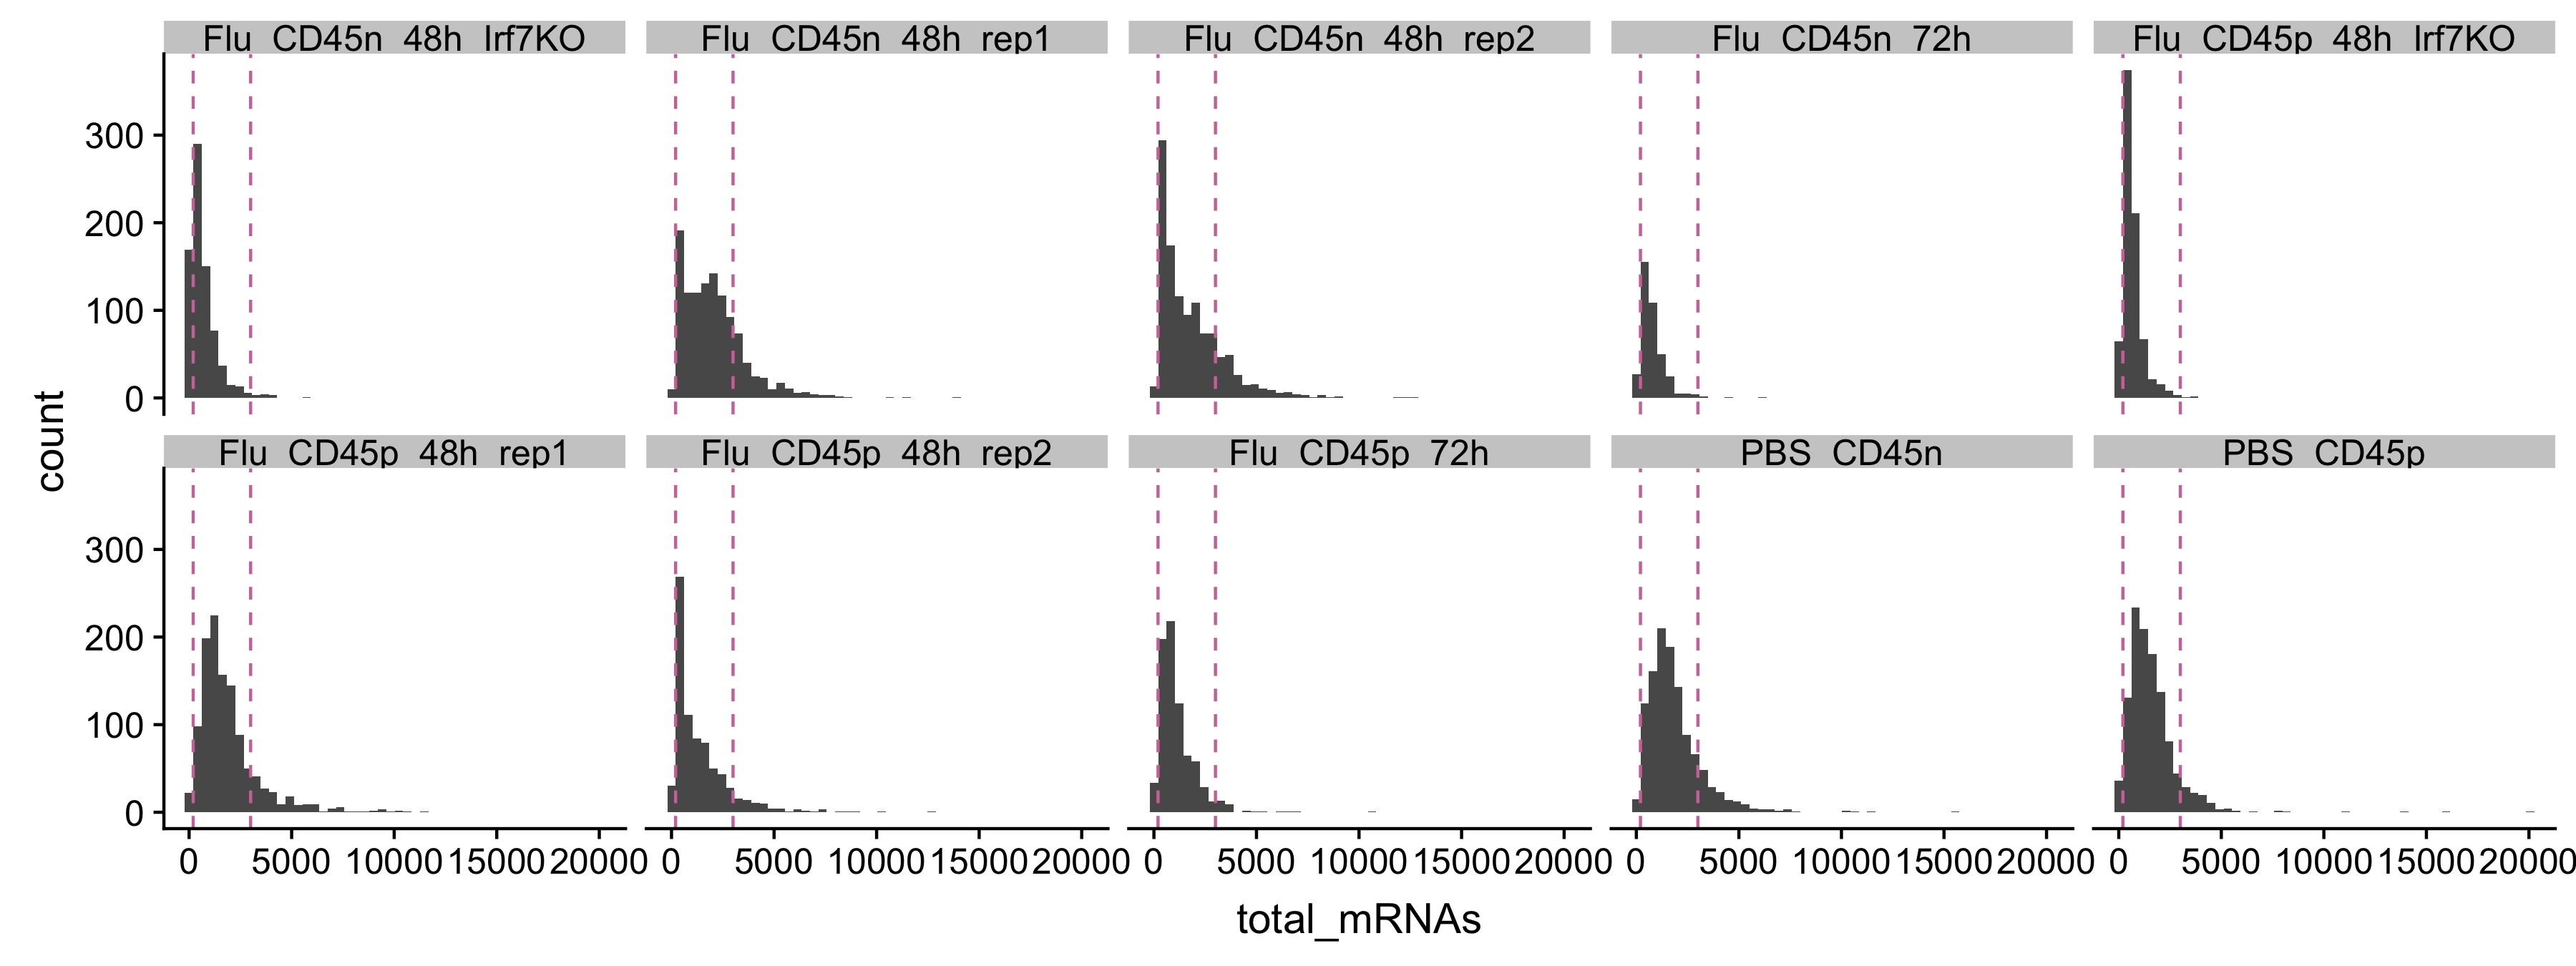

In [8]:
min_mRNAs <- 200
max_mRNAs <- 3000

p_mRNA <- ggplot(pData(expr_set), aes(total_mRNAs)) +
  geom_histogram(bins=50) +
  geom_vline(xintercept=min_mRNAs, color=cbPalette[8], linetype='dashed') +
  geom_vline(xintercept=max_mRNAs, color=cbPalette[8], linetype='dashed') +
  facet_wrap(~ sample, ncol=5)

saveShowPlot(p_mRNA, width=12, height=4.5)

One thing that is immediately apparent from the above plot is that they sequenced to very low depth compared to our experiments.
We now remove all cells with less than the threshold number of mRNA counts per cell:

In [9]:
expr_set <- expr_set[, pData(expr_set)$total_mRNAs >= min_mRNAs]
expr_set <- expr_set[, pData(expr_set)$total_mRNAs <= max_mRNAs]

Plot number of cells remaining for each sample:

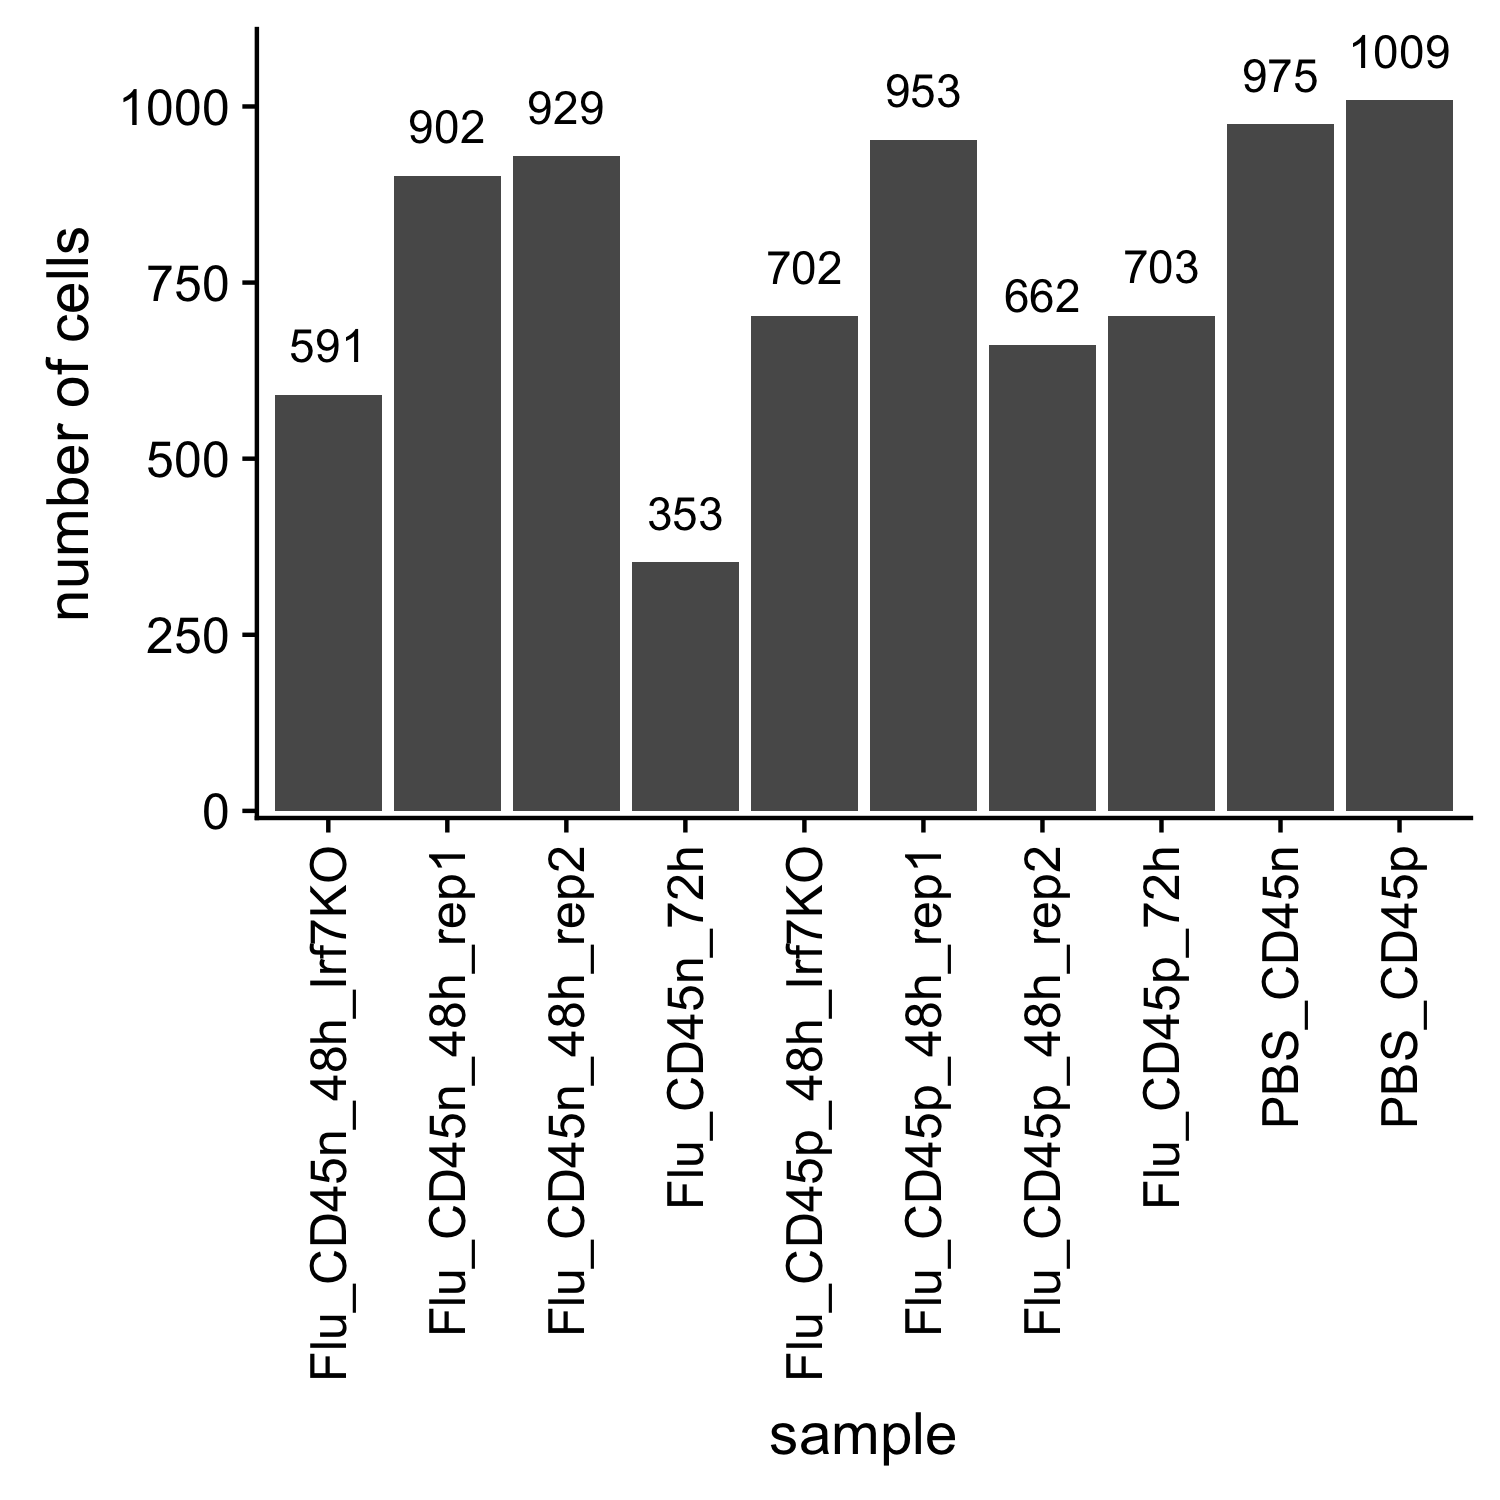

In [10]:
p_ncells <- ggplot(pData(expr_set), aes(sample)) +
  geom_bar() +
  geom_text(stat="count", aes(label=..count..), vjust=-1) +
  theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)) +
  scale_y_continuous(expand=expand_scale(c(0.01, 0.1))) +
  ylab("number of cells")

saveShowPlot(p_ncells, width=5, height=5)

## Examine viral mRNA, call infected cells
We now compute the number and fraction of mRNA from flu for all remaining cells.

In [11]:
# flu mRNAs, positive sense only
pData(expr_set)$flu_mRNAs <- Matrix::colSums(exprs(expr_set[
  row.names(subset(fData(expr_set), str_detect(gene, regex("FluSegment.*_p")))), ]))

# fraction mRNA from flu
pData(expr_set)$frac_flu <- pData(expr_set)$flu_mRNAs / pData(expr_set)$total_mRNAs

We now want to call *infected* cells.
The [Steuerman et al (2018)](https://doi.org/10.1016/j.cels.2018.05.008) paper calls as infected any cell with at least 0.05% of its mRNA from flu, so we do the same (note that this is a pretty liberal cutoff, as it call as infected quite a few cells with very low flu, including some from the PBS controls).

Below we plot this cutoff.
Because of the wide distribution of fraction of mRNA from flu, we show the x-scale on a log axis, and plot cells with **no** viral mRNA at $10^{-4}$ so that they still show up on the histogram.

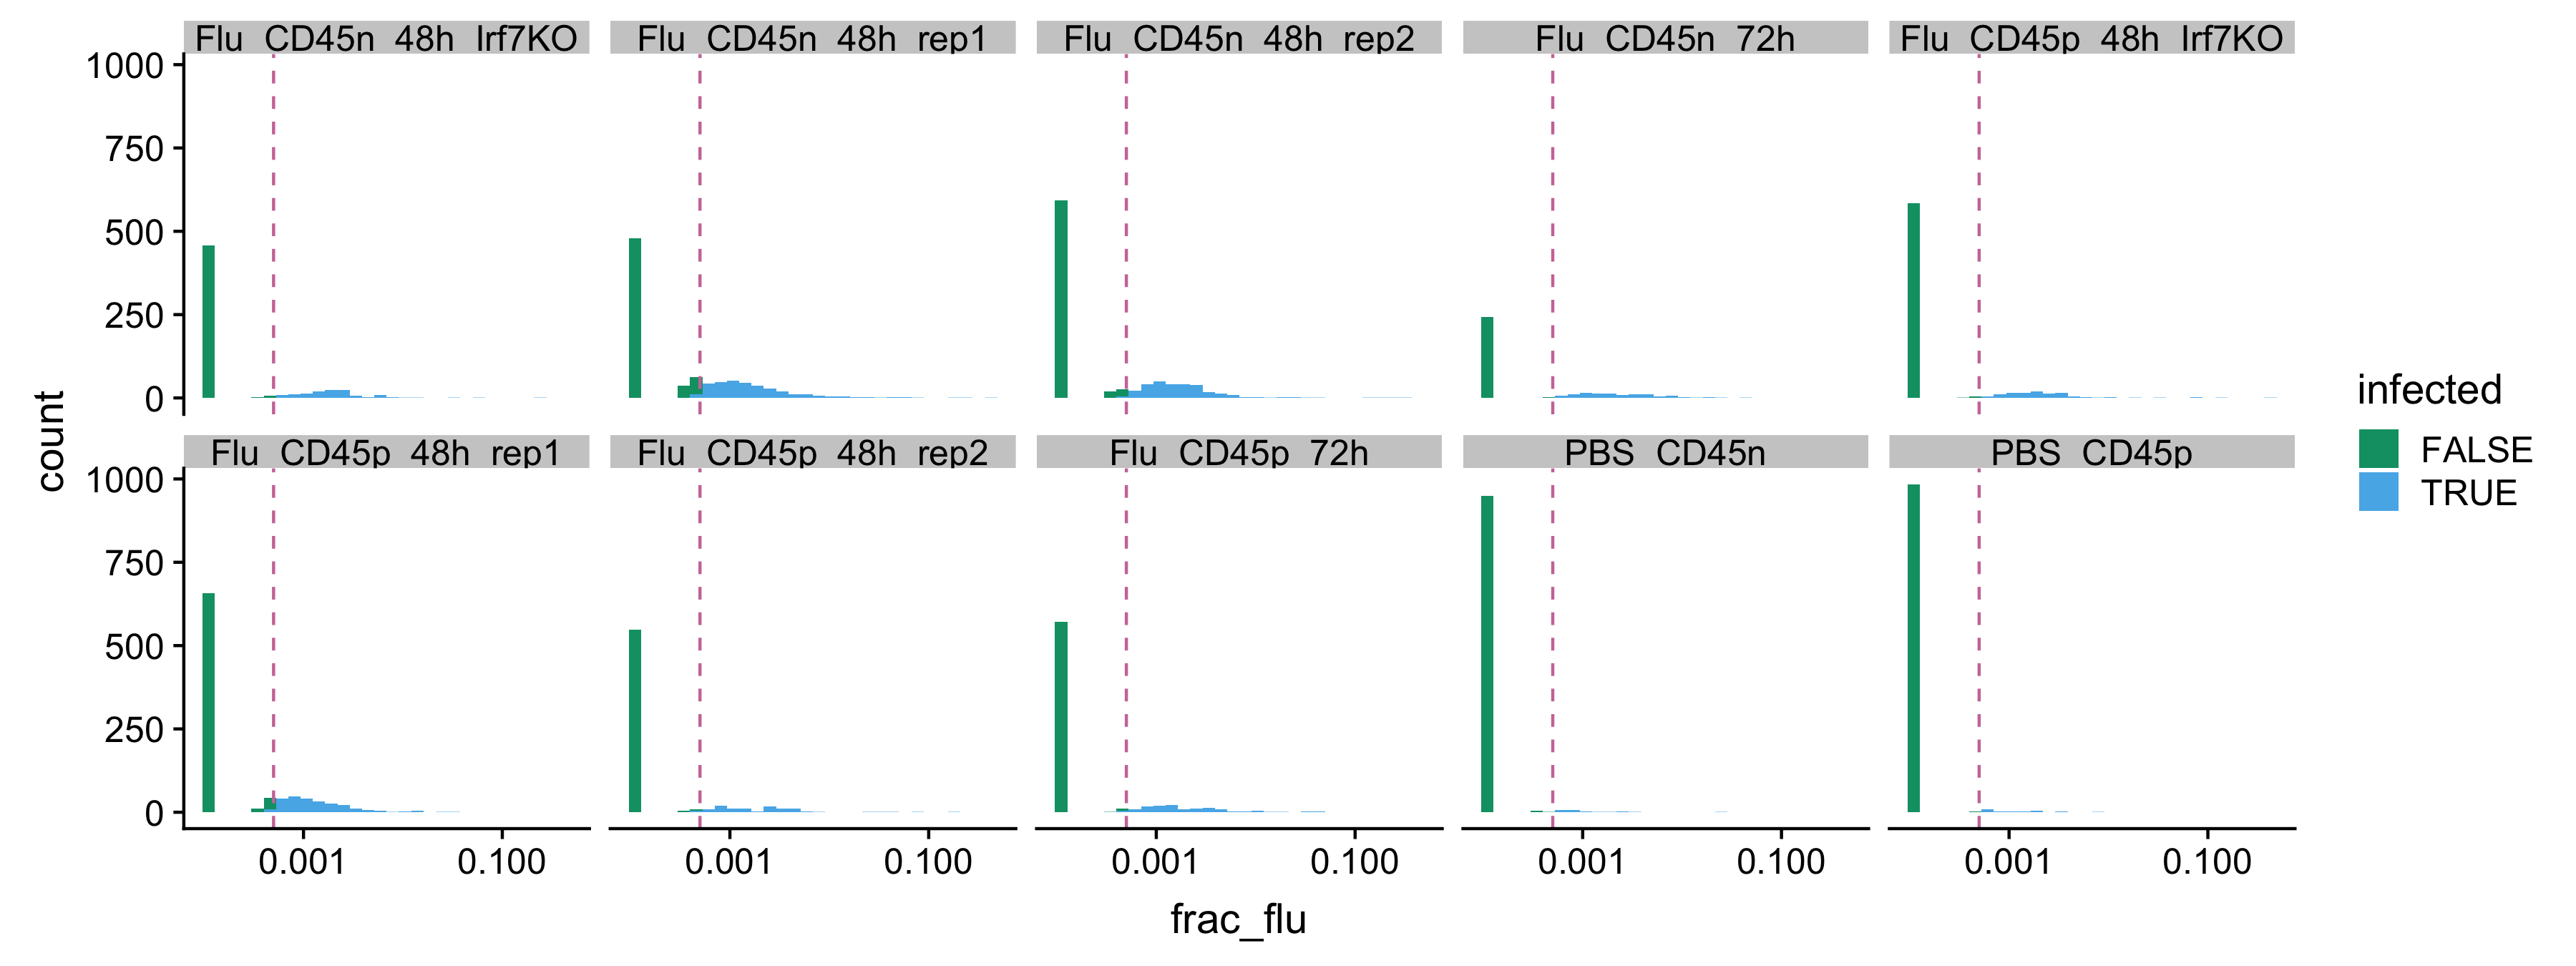

In [12]:
min_frac_flu <- 0.0005

pData(expr_set)$infected <- (pData(expr_set)$frac_flu > min_frac_flu)

p_frac_flu <- ggplot(
    pData(expr_set) %>% mutate(frac_flu=pmax(frac_flu, 1e-4)),
      aes(frac_flu, fill=infected)) +
  scale_fill_manual(values=c(cbPalette[4], cbPalette[3])) +
  geom_histogram(bins=30) +
  geom_vline(xintercept=min_frac_flu, color=cbPalette[[8]], linetype='dashed') +
  facet_wrap(~ sample, ncol=5) +
  scale_x_log10()

saveShowPlot(p_frac_flu, width=12, height=4.5)

Now we plot number of infected cells given our cutoff above.

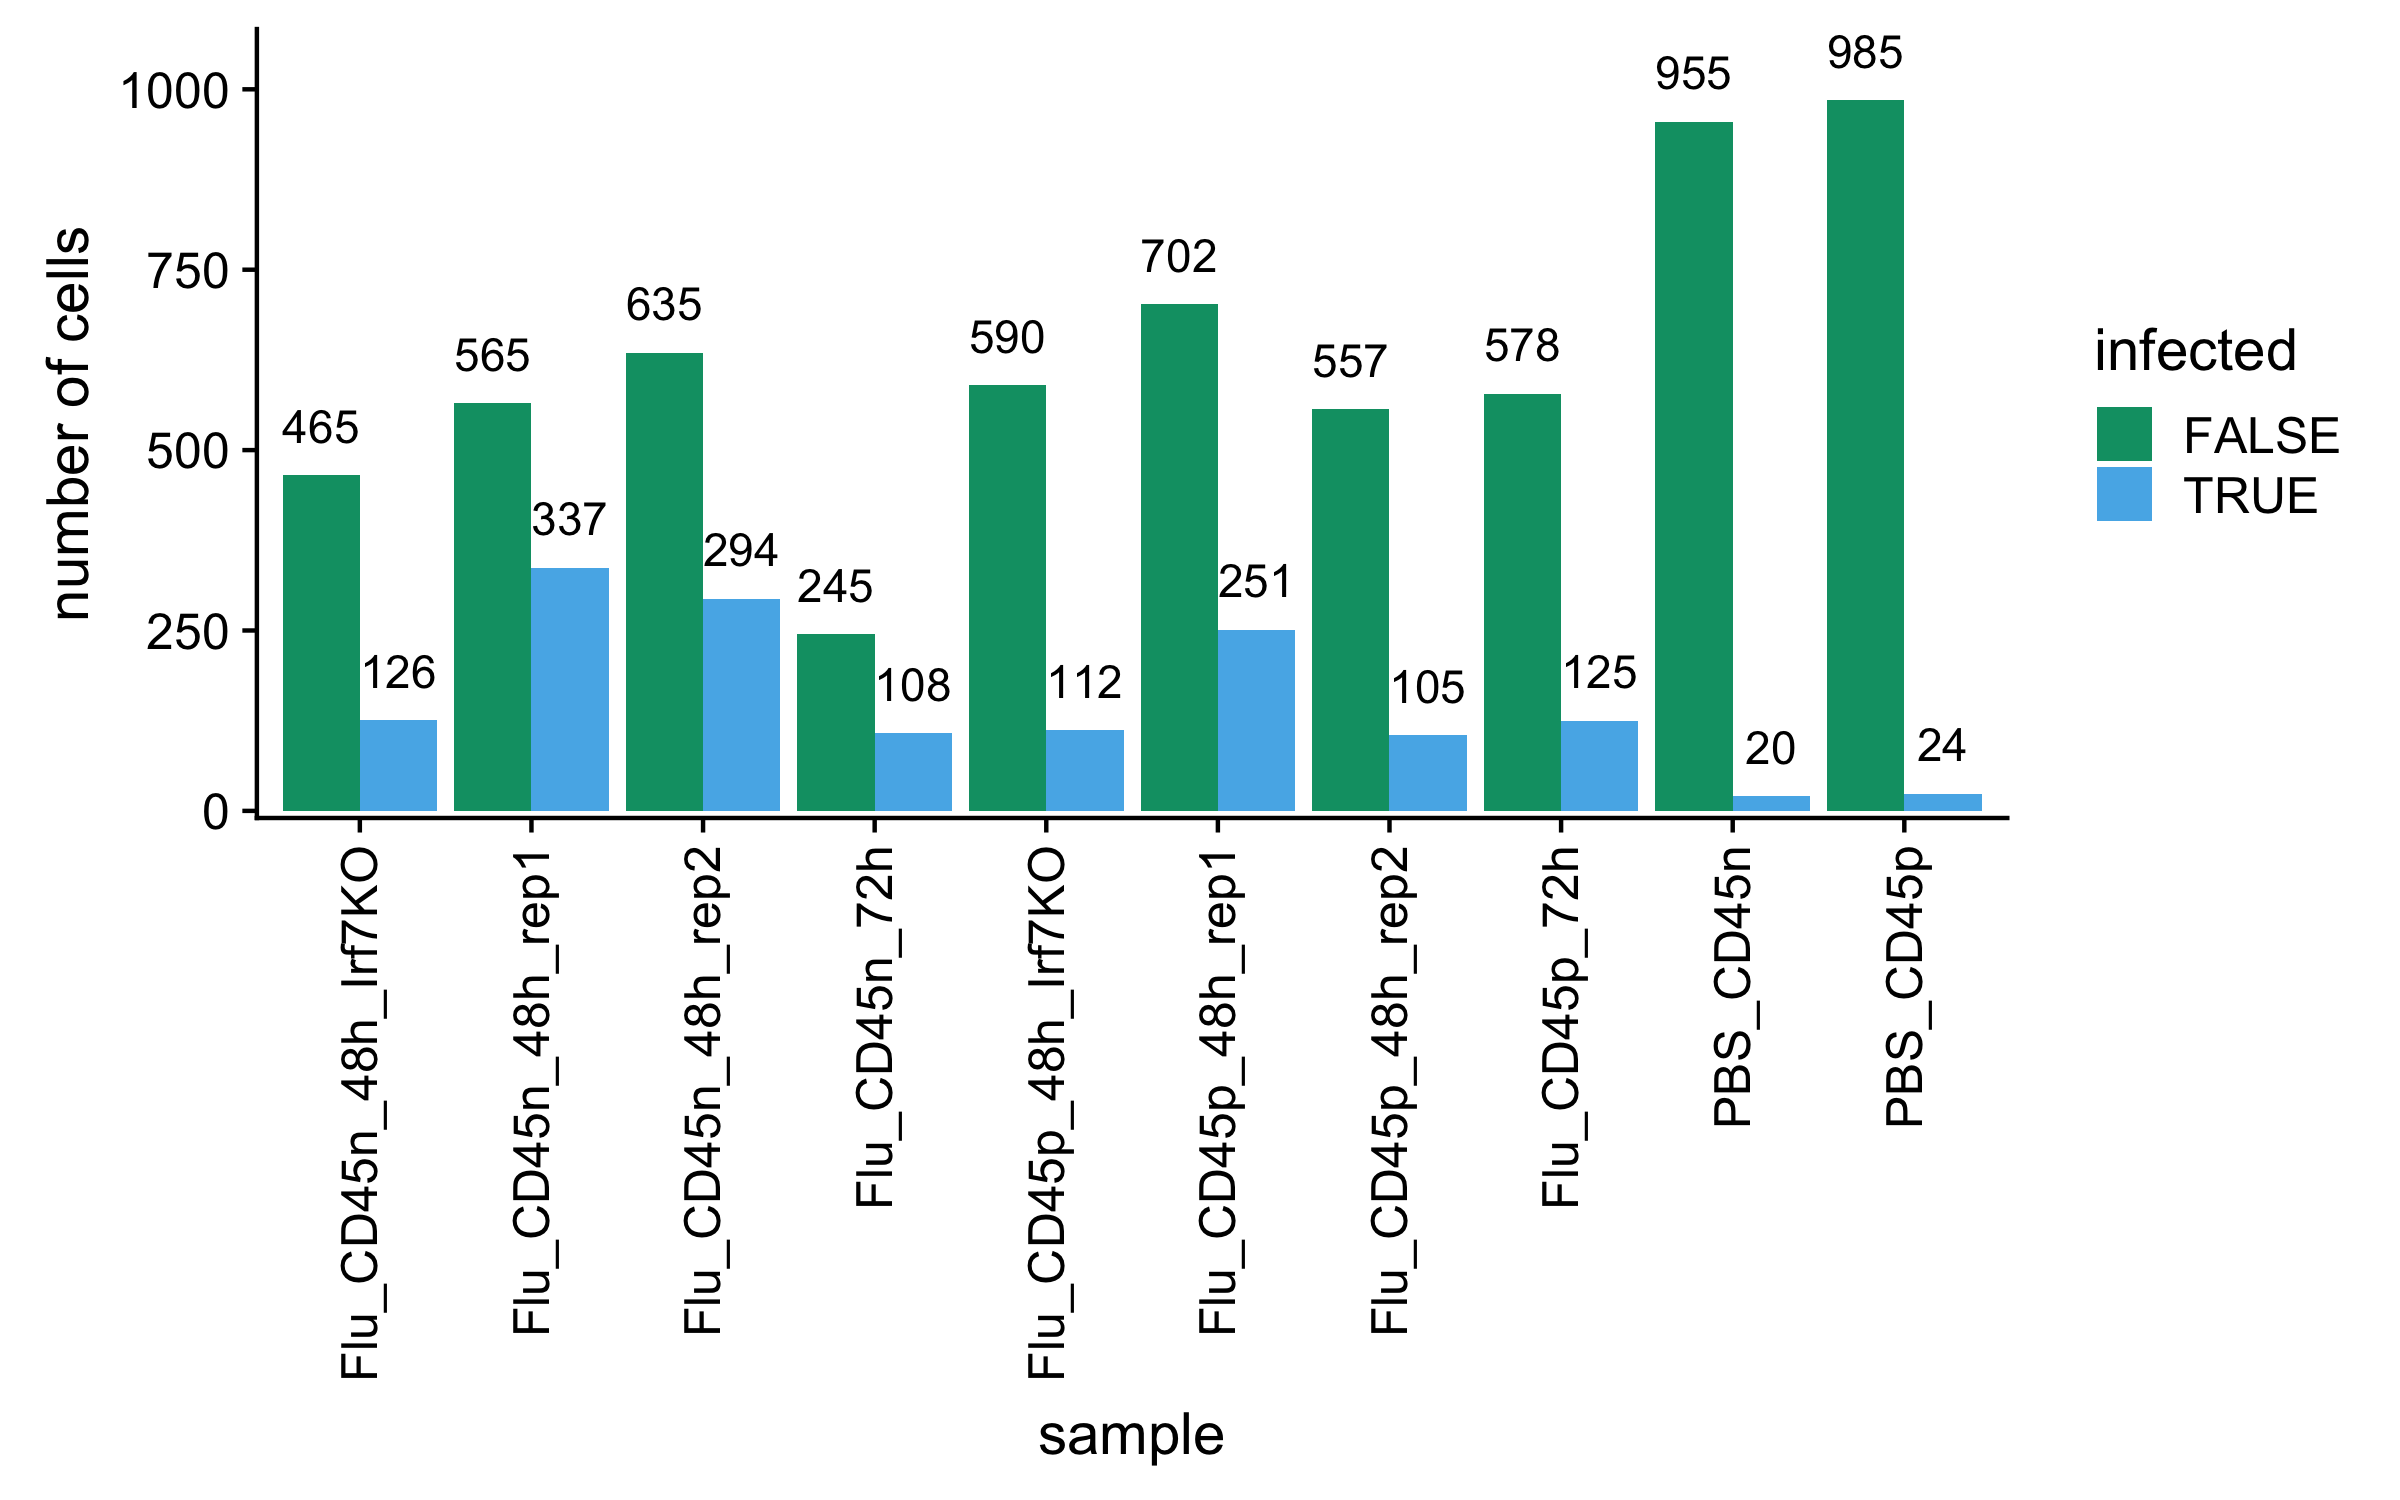

In [13]:
p_ninfected <- ggplot(pData(expr_set), aes(sample, fill=infected)) +
  geom_bar(position=position_dodge()) +
  geom_text(stat="count", aes(label=..count..), vjust=-1, 
    position=position_dodge(width=0.9)) +
  theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)) +
  scale_y_continuous(expand=expand_scale(c(0.01, 0.1))) +
  scale_fill_manual(values=c(cbPalette[[4]], cbPalette[3])) +
  ylab("number of cells")

saveShowPlot(p_ninfected, width=8, height=5)

Reassuringly, most of the flu positive cells are in the flu-infected samples.
However, there is clearly some background of false positive infected cells even in the mock-infected mice.

## Examine IFN and ISG mRNA
We will now annotate cells by the number of type I IFN, type III IFN, and ISG mRNA counts.

For ISGs, we just pick four genes that are typically highly expressed in influenza-infected cells:

In [14]:
isg_genes <- c("Ccl5", "Isg15", "Ifit1", "Mx1")
stopifnot(isg_genes %in% fData(expr_set)$gene)

cat("Counting the following as ISGs:", isg_genes)

Counting the following as ISGs: Ccl5 Isg15 Ifit1 Mx1

For type I IFN genes, we get all IFNalpha and IFNbeta genes:

In [15]:
IFN_I_genes <- fData(expr_set) %>% 
  filter(str_detect(gene, regex("Ifn(a|b)\\d+"))) %$%
  gene %>% 
  as.character

cat("Counting the following as type I IFN:", IFN_I_genes)

Counting the following as type I IFN: Ifna1 Ifna11 Ifna12 Ifna13 Ifna14 Ifna2 Ifna4 Ifna5 Ifna6 Ifna7 Ifna9 Ifnb1

For type III IFN genes, we get IL29, IL28A, and IL28B (although there doesn't appear to be any IL29 gene):

In [16]:
IFN_III_genes <- fData(expr_set) %>%
  filter(str_detect(gene, regex("Il2(8|9)(a|b)"))) %$%
  gene %>%
  as.character

cat("Counting the following as type III IFN:", IFN_III_genes)

Counting the following as type III IFN: Il28a Il28b

Now compute then number and fraction of mRNA from each of these categories of genes:

In [17]:
pData(expr_set)$ISG_mRNAs <- Matrix::colSums(exprs(expr_set[
  row.names(subset(fData(expr_set), gene %in% isg_genes)), ]))
pData(expr_set)$ISG_frac <- pData(expr_set)$ISG_mRNAs / pData(expr_set)$total_mRNAs

pData(expr_set)$IFN_I_mRNAs <- Matrix::colSums(exprs(expr_set[
  row.names(subset(fData(expr_set), gene %in% IFN_I_genes)), ]))
pData(expr_set)$IFN_I_frac <- pData(expr_set)$IFN_I_mRNAs / pData(expr_set)$total_mRNAs

pData(expr_set)$IFN_III_mRNAs <- Matrix::colSums(exprs(expr_set[
  row.names(subset(fData(expr_set), gene %in% IFN_III_genes)), ]))
pData(expr_set)$IFN_III_frac <- pData(expr_set)$IFN_III_mRNAs / pData(expr_set)$total_mRNAs

Now we plot the fraction of mRNA from each of these categories of IFN or ISG positive cells:

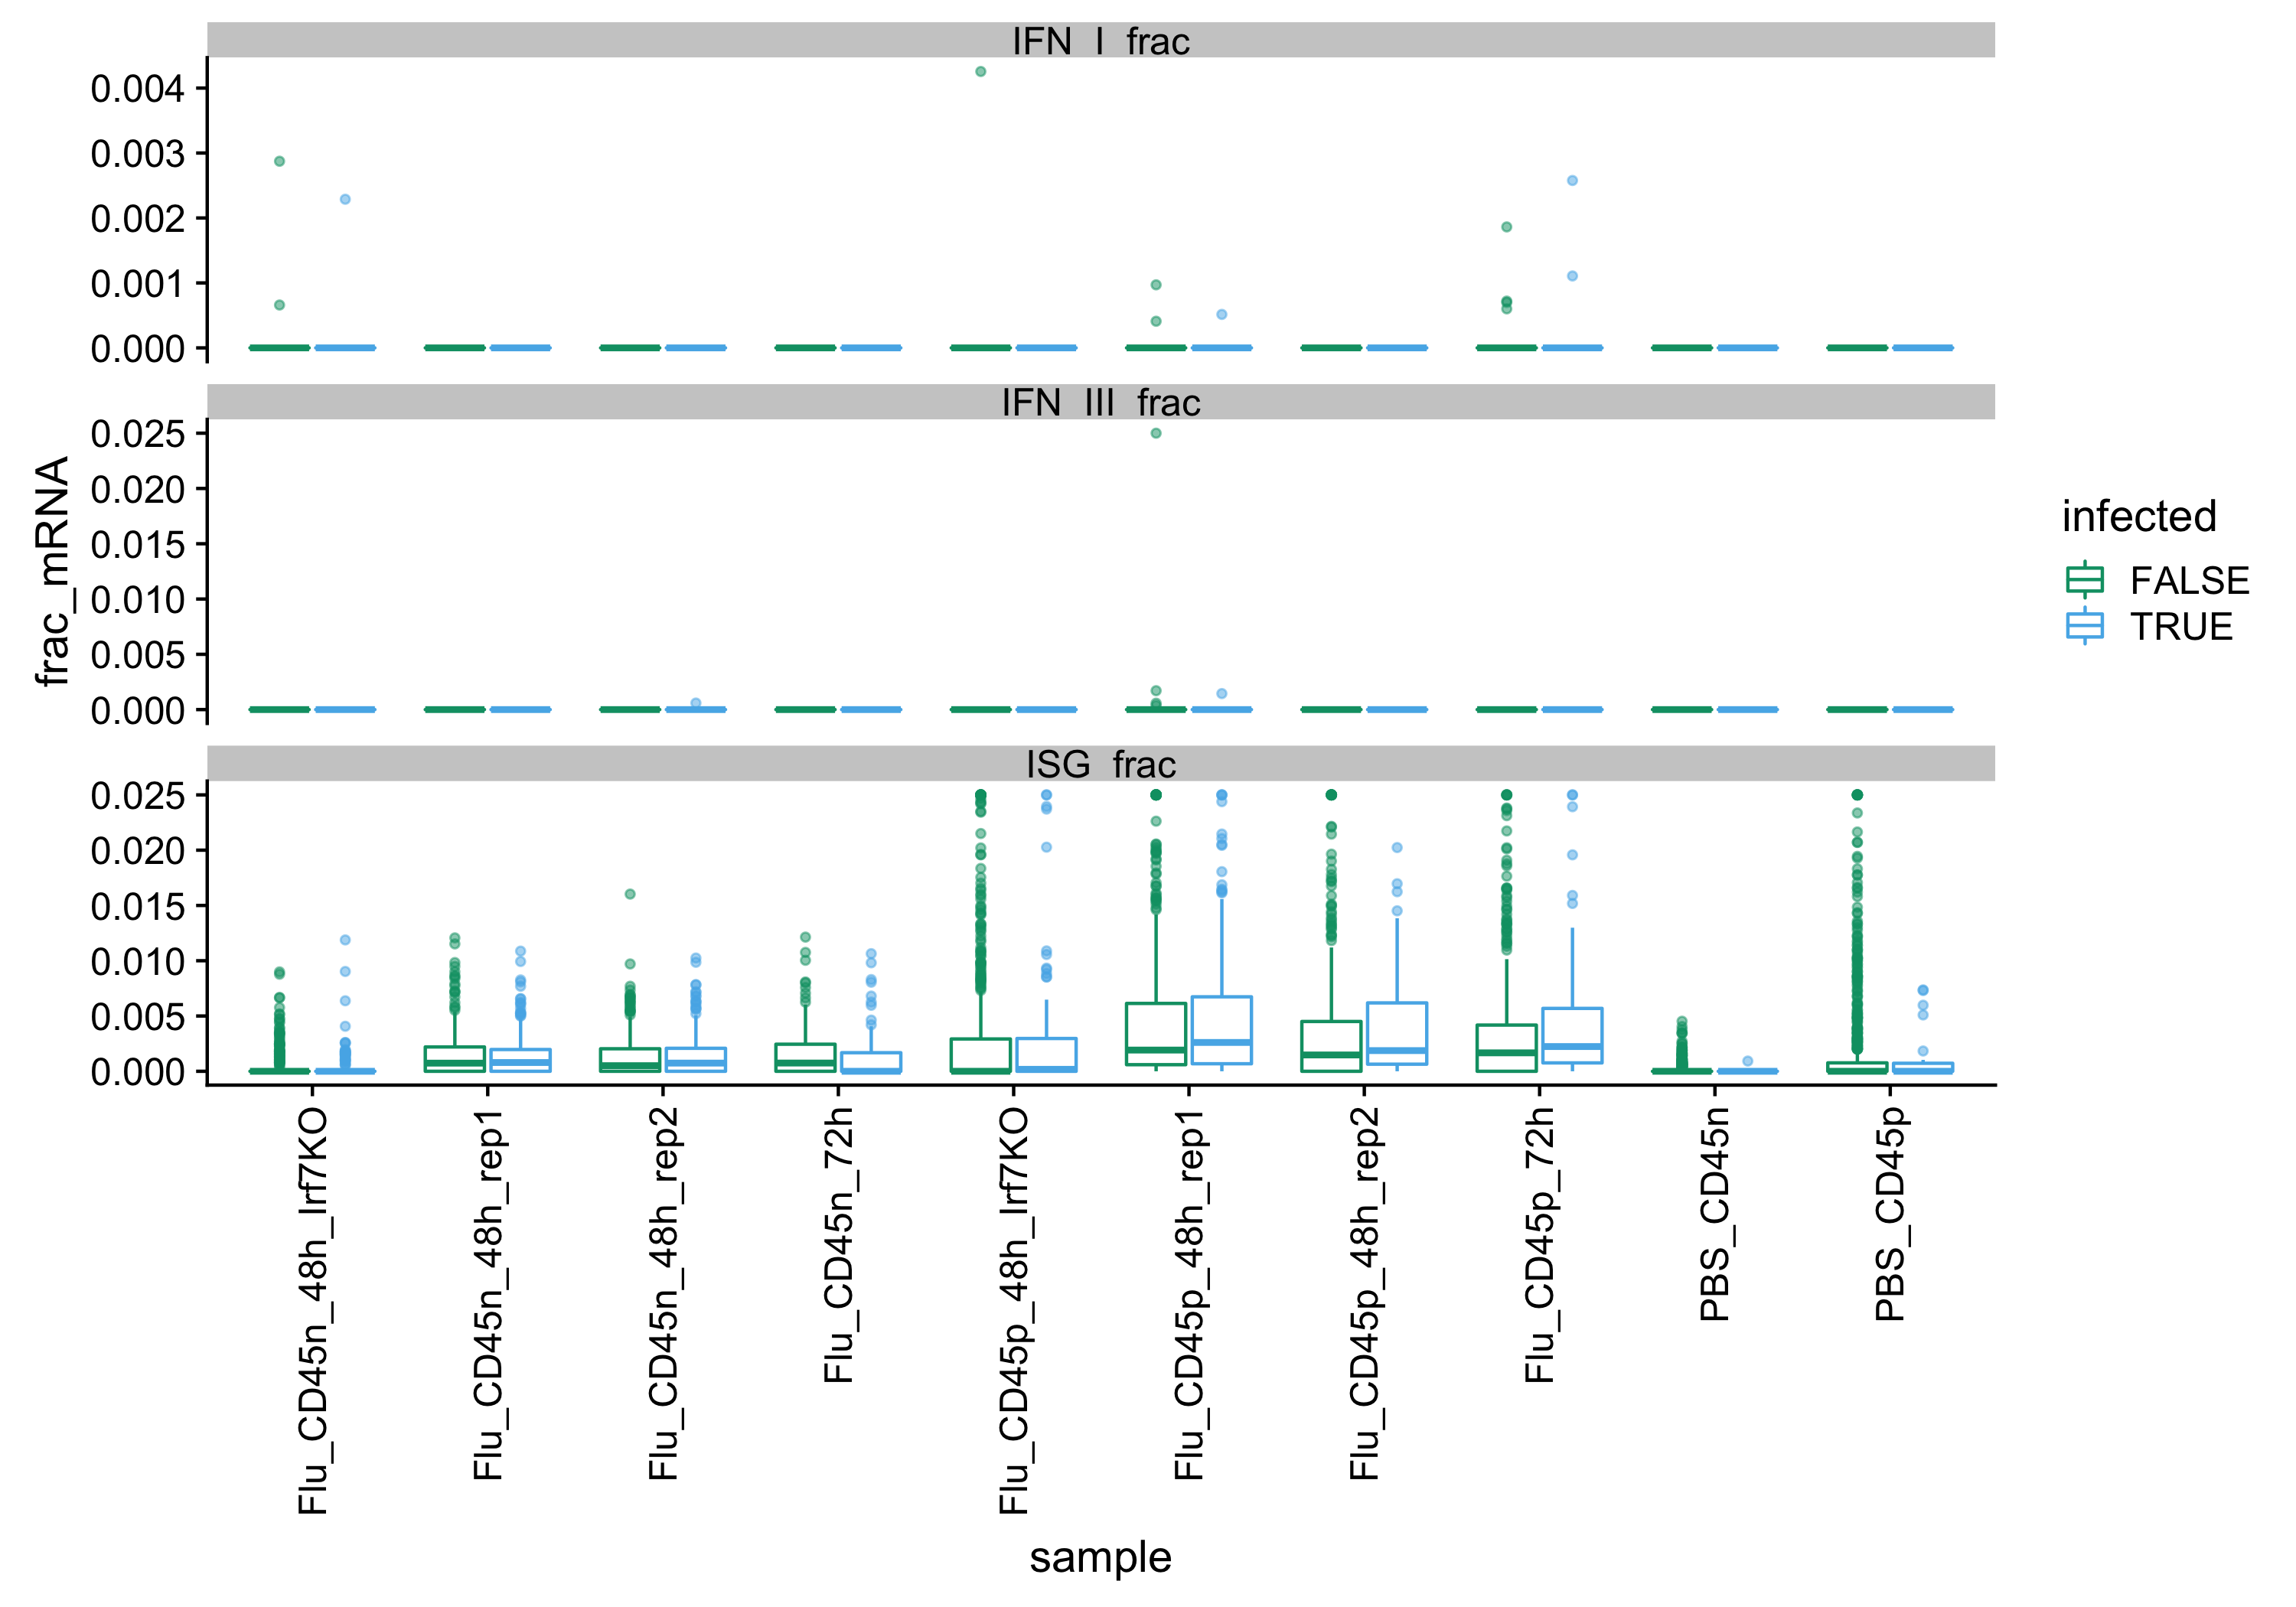

In [18]:
ymax <- 0.025 # ymax, any points > this shown as this

p_ISG_IFN_frac <- ggplot(
    pData(expr_set) %>%
      select(sample, infected, ISG_frac, IFN_I_frac, IFN_III_frac) %>%
      gather(gene_type, frac_mRNA, ISG_frac, IFN_I_frac, IFN_III_frac) %>%
      mutate(frac_mRNA=pmin(ymax, frac_mRNA)),
    aes(sample, frac_mRNA, color=infected)) +
  geom_boxplot(outlier.color=NULL, outlier.size=1, outlier.alpha=0.5) +
  theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)) +
  facet_wrap(~gene_type, ncol=1, scales='free_y') +
  scale_color_manual(values=c(cbPalette[4], cbPalette[3]))

saveShowPlot(p_ISG_IFN_frac, width=10, height=7)

We see that very few cells express any detectable IFN, and those cells that do are sprinkled among samples and infected an uninfected cells.
Many cells express ISGs, and the ISG expression is higher among samples that were flu-infected (versus PBS controls) and that have IRF7 (versus IRF7 KO), as expected.

## Filter to cells from infected wildtype mice
For the remainder of the analysis, we will compute stats only on infected cells from **wildtype** mice (ignoring IRF7 KO).

We also combine the type I and type III IFN mRNAs into a single category that we name *IFN*.

Get these cells in a tidy data frame:

In [19]:
cells <- pData(expr_set) %>% 
  filter(infected & (! str_detect(sample, "PBS")) & (! str_detect(sample, "Irf7KO"))) %>%
  mutate(IFN=IFN_I_mRNAs + IFN_III_mRNAs,
         ISG=ISG_mRNAs,
         total=total_mRNAs,
         flu=flu_mRNAs) %>%
  select(sample, ISG, IFN, total) %>%
  gather(gene_type, mRNAs, -sample) %>%
  mutate(zero_count=mRNAs == 0) %>%
  transform(gene_type=factor(gene_type, c("total", "ISG", "IFN"))) %>%
  mutate(fillcolor=ifelse(zero_count | gene_type == 'total', 'green',
         ifelse(gene_type == 'ISG', 'red', 'orange')))

## Plot number of mRNAs (total, IFN, ISG)
Among our filtered and flu-infected cells, we now plot the number of mRNAs in each category.
This plot shows several things:
 1. Sequencing depth is low, such that the typical cell only has about 1500 mRNAs observed.
 2. Most of the cells have very little flu mRNA
 3. There are very few IFN+ cells, but quite a bit more ISG+. However, the caveat is that we may not detect these transcripts well since the sequencing depth is so low.

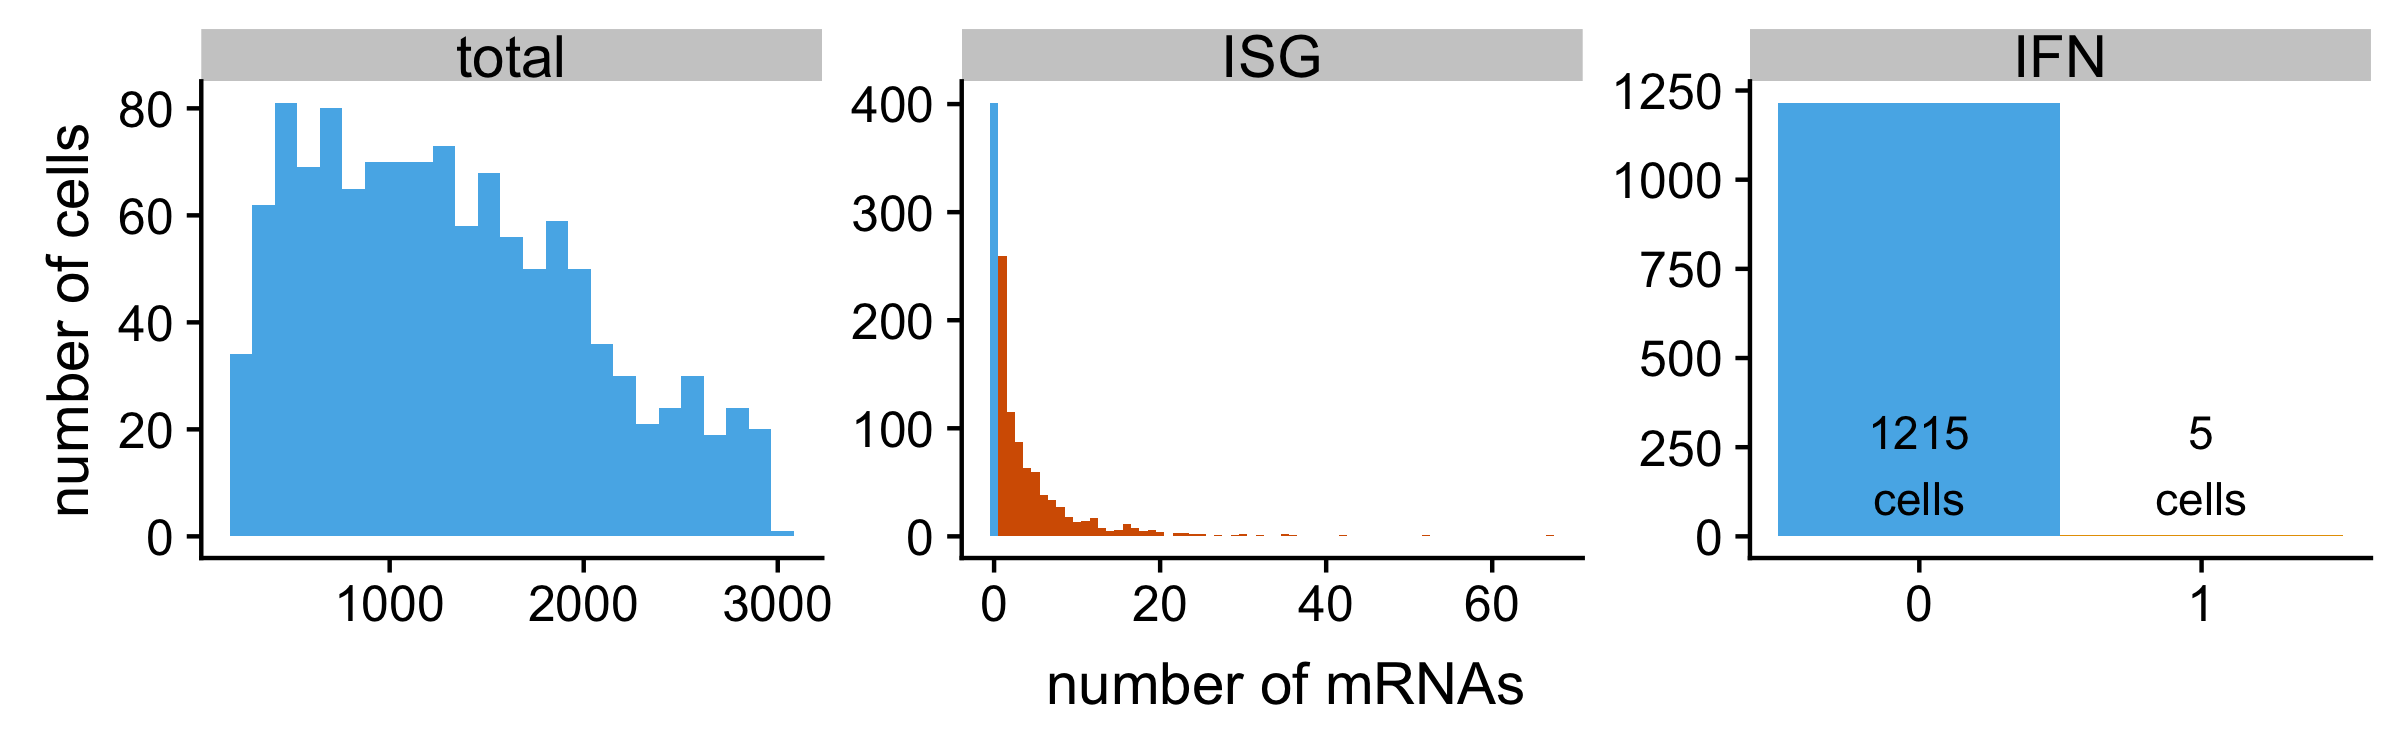

In [20]:
p_mRNA_counts <- ggplot(
    cells, aes(mRNAs, fill=fillcolor)) +
  geom_histogram(data=subset(cells, gene_type == "total"), bins=25) +
  geom_histogram(data=subset(cells, gene_type == "ISG"), binwidth=1) + 
  geom_histogram(data=subset(cells, gene_type == "IFN"), binwidth=1) + 
  facet_wrap(~ gene_type, nrow=1, scales='free') + 
  geom_text(data=subset(cells, gene_type == "IFN") %>% head(n=1),
    aes(x=0, y=200,
      label=paste(
        cells %>% 
          filter(gene_type == "IFN", zero_count == TRUE) %>%
          nrow,
        "cells",
        sep="\n")
    )) +
  geom_text(data=subset(cells, gene_type == "IFN") %>% head(n=1),
    aes(x=1, y=200,
      label=paste(
        cells %>% 
          filter(gene_type == "IFN", zero_count == FALSE) %>%
          nrow,
        "cells",
        sep="\n")
    )) +
  ylab("number of cells") +
  xlab("number of mRNAs") +
  scale_fill_manual(values=c(cbPalette[3], cbPalette[2], cbPalette[7])) +
  scale_x_continuous(breaks=scales::pretty_breaks(n=3)) +
  theme(strip.text=element_text(size=14), legend.position='none')

saveShowPlot(p_mRNA_counts, width=8, height=2.5)